In [23]:
import pandas as pd
from tqdm.notebook import tqdm
from ms_entropy.file_io.msp_file import read_one_spectrum
import random
import numpy as np
from matplotlib import pyplot as plt

from rdkit import RDLogger
import importlib

import sys
sys.path.append('../../src/')
from ms_similarity_metrics.hash_utils import hash_spectrum
from ms_similarity_metrics.create_spectrum import create_spectra_NIST23, create_spectra_wout
from ms_similarity_metrics.query_pool import query, call_modified_cosine
from ms_similarity_metrics.frequency import get_weights
importlib.reload(sys.modules['ms_similarity_metrics.hash_utils'])
importlib.reload(sys.modules['ms_similarity_metrics.create_spectrum'])
importlib.reload(sys.modules['ms_similarity_metrics.query_pool'])
importlib.reload(sys.modules['ms_similarity_metrics.frequency'])
from ms_similarity_metrics.hash_utils import hash_spectrum
from ms_similarity_metrics.create_spectrum import create_spectra_NIST23, create_spectra_wout
from ms_similarity_metrics.create_spectrum import weight_NIST23_spectra, weight_wout_spectra
from ms_similarity_metrics.query_pool import query, call_modified_cosine
from ms_similarity_metrics.frequency import get_weights


In [2]:
RDLogger.DisableLog('rdApp.*')

In [3]:
%matplotlib inline

# Get NIST library data

In [4]:
# Get NIST23 library
spectra_list = []

# Get data from s3://enveda-data-user/chloe.engler/cosine_similarity/NIST_data/NIST23-HR-MSMS.MSP
for i,spectrum in tqdm(enumerate(read_one_spectrum('../../data/NIST23-HR-MSMS.MSP'))):
    spectra_list.append(spectrum)

0it [00:00, ?it/s]

In [5]:
# read tsv file
inchikey_nist23_to_smiles = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/random/nist23_resolver_inchikeys_to_smiles.tsv.gz',
    sep='\t',
    compression='gzip',
)

In [6]:
# remove rows where smiles is nan
inchikey_nist23_to_smiles = inchikey_nist23_to_smiles.dropna(subset=['smiles'])

# make a dict from inchikey to smiles
inchikey_to_smiles = dict(zip(inchikey_nist23_to_smiles['inchikey'], inchikey_nist23_to_smiles['smiles']))

In [7]:
# Convert spectra to right format and filter
# See create_spectrum.py for more filtering information
nist_spectra, info_dict, nist_inchi_dict = create_spectra_NIST23(spectra_list, inchikey_to_smiles, min_n_peaks=6)

1934658it [00:54, 35549.26it/s] 


# Get GNPS data

In [8]:
# Covert spectra to right format and filter
# Get data from s3://enveda-data-user/chloe.engler/cosine_similarity/Wout_data/ALL_GNPS_NO_PROPOGATED.mgf
wout_spectra, wout_info_dict = create_spectra_wout(
    '../../data/ALL_GNPS_NO_PROPOGATED.mgf',
    min_n_peaks=6,
)

0it [00:00, ?it/s]

495600it [02:49, 2915.76it/s] 


In [9]:
# Get wout metadata
metadata = pd.read_csv(
    'https://zenodo.org/record/6829249/files/gnps_libraries_metadata.csv?download=1'
)
metadata.set_index('id', inplace=True)

# Get overlapping spectra

In [10]:
# Get set with all inchis from nist spectra
nist_inchis = {
    spectra.partial_inchikey
    for spectra in tqdm(nist_spectra)
}

  0%|          | 0/402412 [00:00<?, ?it/s]

In [11]:
# Check for matching spectra in NIST23 and wout
matching_inchis = []
for i,spectra in enumerate(tqdm(wout_spectra)):
    current_inchi = spectra.partial_inchikey
    if current_inchi != None and current_inchi in nist_inchis:
        matching_inchis.append(current_inchi)

  0%|          | 0/59165 [00:00<?, ?it/s]

In [12]:
# Get data from s3://enveda-data-user/chloe.engler/cosine_similarity/Wout_data/matching_inchis.txt
with open('../../data/matching_inchis.txt', 'w') as f:
    for inchi in matching_inchis:
        f.write(inchi + '\n')

In [13]:
print('Number of overlapping spectra: ', len(matching_inchis))
print('Number of overlapping structures: ', len(set(matching_inchis)))

Number of overlapping spectra:  30100
Number of overlapping structures:  3193


In [14]:
# Get ppm values for Wout spectra
wout_ppm = pd.read_csv('s3://enveda-data-user/chloe.engler/cosine_similarity/Wout_data/wout_ppm_corrected.csv')
wout_ppm.set_index('spectrumid', inplace=True)

# Get hashes for the NIST23 data

In [15]:
# dict of all hashes for all spectra in NIST23
all_hashes = {
    s.identifier: hash_spectrum(s.mz, s.intensity, precision=2, iterative=True, sort=True)
    for s in tqdm(nist_spectra)
}

  0%|          | 0/402412 [00:00<?, ?it/s]

# Add weights

In [16]:
# Get wout frequency df
frequency_df = pd.read_csv('s3://enveda-data-user/chloe.engler/cosine_similarity/Wout_data/frequency_df.csv', index_col=0)
frequency_df = frequency_df.set_index('mz')
min_frequency = min(frequency_df.index.values)
max_frequency = max(frequency_df.index.values)
new_frequency_df = frequency_df.copy()

# Extend weights to other m/z values
for mz in tqdm(np.arange(min_frequency, max_frequency, 0.1)):
    mz = np.round(mz, 1)
    if mz not in frequency_df.index.values:
        lower_bound = frequency_df[frequency_df.index < mz].index.max()
        upper_bound = frequency_df[frequency_df.index > mz].index.min()
        prob_value = (frequency_df.loc[lower_bound, 'prob'] + frequency_df.loc[upper_bound, 'prob'])/2
        new_frequency_df.loc[mz] = [0, prob_value]
for mz in tqdm(np.arange(0, min_frequency, 0.1)):
    mz = np.round(mz, 1)
    new_frequency_df.loc[mz] = [0, frequency_df.loc[min_frequency]['prob']]
for mz in tqdm(np.arange(max_frequency, 5000, 0.1)):
    mz = np.round(mz, 1)
    new_frequency_df.loc[mz] = [0, frequency_df.loc[max_frequency]['prob']]

new_frequency_df = new_frequency_df.sort_index()
new_frequency_df['mz'] = np.round(new_frequency_df.index.values, 1)
new_frequency_df = new_frequency_df.set_index('mz', drop=True)


  0%|          | 0/31909 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/18045 [00:00<?, ?it/s]

In [17]:
# Define weight functions
intensity_weights = lambda x: x**(1/4)
mz_weights = lambda x: x**(1/4)
weight_df = get_weights(new_frequency_df, mz_weights, weight_col='prob')

In [18]:
# Weight nist and wout spectra
weighted_nist_spectra = weight_NIST23_spectra(nist_spectra, intensity_weights, weight_df)
weighted_wout_spectra = weight_wout_spectra(wout_spectra, intensity_weights, weight_df)

402412it [03:25, 1962.81it/s]
100%|██████████| 59165/59165 [00:29<00:00, 1975.35it/s]


# Query the NIST23 library

### Filter query spectra

In [19]:
# Filter query spectra to only those with matching inchikey
filtered_query_spectra = [i for i in range(len(weighted_wout_spectra)) if weighted_wout_spectra[i].partial_inchikey in matching_inchis]

# Filter query spectra to only those that are not in the NIST library
filtered_query_spectra = [i for i in filtered_query_spectra if 
                            metadata.loc[weighted_wout_spectra[i].identifier,'library'] != 'GNPS-NIST14-MATCHES']

# Filter query spectra to only those that have a ppm value between -100 and 100
filtered_query_spectra = [i for i in filtered_query_spectra if weighted_wout_spectra[i].identifier 
                            in wout_ppm.index.values]
filtered_query_spectra = [i for i in filtered_query_spectra if 
                            abs(wout_ppm.loc[weighted_wout_spectra[i].identifier, 'ppm']) < 100]


### Get tanimoto scores

In [20]:
from rdkit import Chem, DataStructs
import functools

@functools.lru_cache
def _smiles_to_mol(smiles):
    try:
        return Chem.MolFromSmiles(smiles)
    except:
        return None
@functools.lru_cache
def tanimoto(smiles1, smiles2):
    mol1, mol2 = _smiles_to_mol(smiles1), _smiles_to_mol(smiles2)
    if mol1 is None or mol2 is None:
        return np.nan
    fp1, fp2 = Chem.RDKFingerprint(mol1), Chem.RDKFingerprint(mol2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)



In [21]:
# Get dictionary of partial inchikeys
inchikeys = {}
for s in tqdm(nist_spectra):
    inchikeys[s.identifier] = s.partial_inchikey

  0%|          | 0/402412 [00:00<?, ?it/s]

  0%|          | 0/25486 [00:00<?, ?it/s]

  0%|          | 0/402412 [00:00<?, ?it/s]

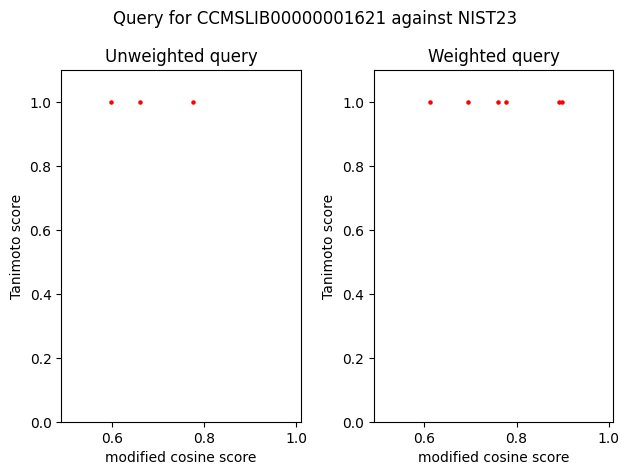

  0%|          | 0/402412 [00:00<?, ?it/s]

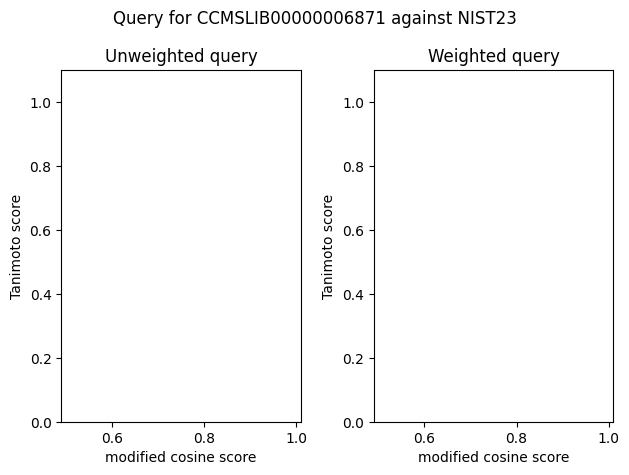

  0%|          | 0/402412 [00:00<?, ?it/s]

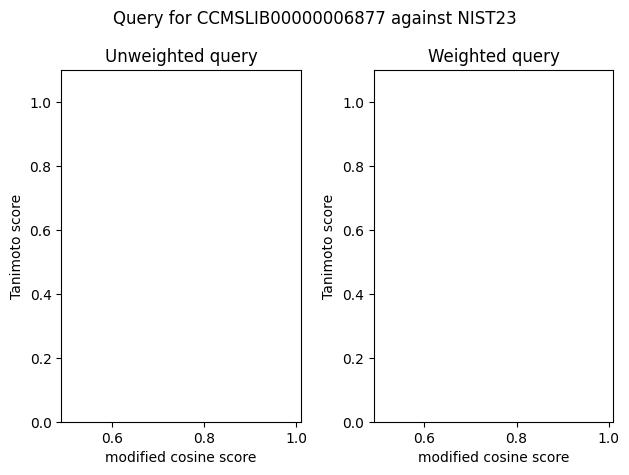

  0%|          | 0/402412 [00:00<?, ?it/s]

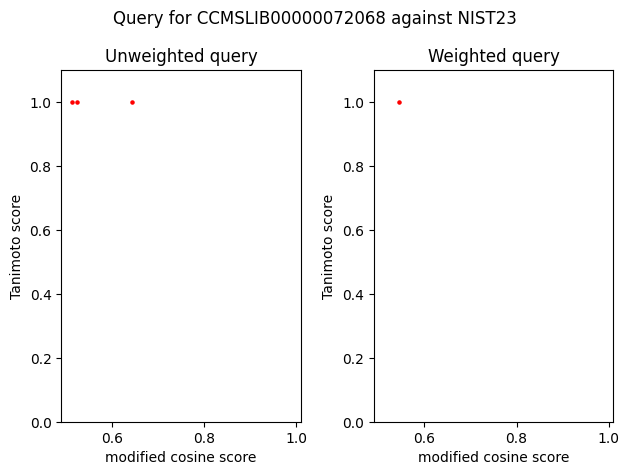

  0%|          | 0/402412 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [24]:
# Find the best matches for the first matching spectra
j = 0
shuffled_indexes = np.arange(len(weighted_wout_spectra))
np.random.seed(1)
random.shuffle(shuffled_indexes)

for i in tqdm(filtered_query_spectra):
    query_spectra = wout_spectra[i]
    weighted_query_spectra = weighted_wout_spectra[i]
    if query_spectra.partial_inchikey in matching_inchis \
        and metadata.loc[query_spectra.identifier, 'library'] != 'GNPS-NIST14-MATCHES' :
        j+=1

        # Check that the spectra identifiers match
        if query_spectra.identifier != weighted_query_spectra.identifier:
            raise ValueError('Spectra identifiers do not match')

        # Find the best matches for unweighted spectra
        (best_matches, identical_matches), num_matches, num_matches_in_quereies = query(
            query_spectra, 
            nist_spectra, 
            all_hashes,
            nist_inchi_dict=nist_inchi_dict,
            metric_type='modified_cosine',
            #metric_type=['bhattacharya_2', 'manhattan', 'entropy'],
            threshold=0.5,
            ppm_window=10
        )

        # Find the best matches for weighted spectra
        (weighted_best_matches, weighted_identical_matches), num_matches, num_matches_in_query = query(
            weighted_query_spectra, 
            weighted_nist_spectra, 
            all_hashes,
            nist_inchi_dict=nist_inchi_dict,
            metric_type='modified_cosine',
            #metric_type=['bhattacharya_2', 'manhattan', 'entropy'],
            threshold=0.5,
            ppm_window=10
        )

        exact_match_indexes = [j for j,x in enumerate(best_matches) if inchikeys[x[0]] == query_spectra.partial_inchikey]
        weighted_exact_match_indexes = [j for j,x in enumerate(weighted_best_matches) if inchikeys[x[0]] == query_spectra.partial_inchikey]

        # Get dictionary of tanimoto scores
        tanimotos = {}
        for s in tqdm(nist_spectra):
            tanimotos[s.identifier] = tanimoto(query_spectra.smiles, s.smiles)

        # Sort tanimoto dict in reverse by value
        tanimotos_sorted = sorted(tanimotos.items(), key=lambda x: x[1], reverse=True)
        tanimotos = {k:v for k,v in tanimotos_sorted}

        # Plot tanimoto vs modified cosine
        x = np.array([x[1] for x in best_matches])
        y = np.array([tanimotos[x[0]] for x in best_matches])
        plt.subplot(1,2,1)
        plt.scatter(x,y,s=1,color='darkseagreen')
        plt.scatter(x[exact_match_indexes],y[exact_match_indexes],s=5,color='red')
        plt.ylim(0,1.1)
        plt.xlim(0.49,1.01)
        plt.xlabel('modified cosine score')
        plt.ylabel('Tanimoto score')
        plt.suptitle(f'Query for {query_spectra.identifier} against NIST23')
        plt.title('Unweighted query')

        # Plot tanimoto vs weighted modified cosine
        x = np.array([x[1] for x in weighted_best_matches])
        y = np.array([tanimotos[x[0]] for x in weighted_best_matches])
        plt.subplot(1,2,2)
        plt.ylim(0,1.1)
        plt.xlim(0.49,1.01)
        plt.scatter(x,y,s=2,color='darkseagreen')
        plt.scatter(x[weighted_exact_match_indexes],y[weighted_exact_match_indexes],s=5,color='red')
        plt.xlabel('modified cosine score')
        plt.ylabel('Tanimoto score')
        plt.title('Weighted query')

        plt.tight_layout()
        plt.savefig(f'../../figures/query_points_{query_spectra.identifier}_modified_cosine.png', dpi=400)
        plt.show()

        if j > 19:
            break
